In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

from sklearn import metrics
from sklearn.metrics import r2_score


from itertools import combinations
from sklearn.svm import SVR

In [39]:


Company = pd.read_csv("Amazon_final.csv",index_col=0)
Google_trends_df = pd.read_csv("./New Data/Google_trends_data_updated.csv",index_col=0)
All = pd.read_csv("All.csv",index_col=0)

# Datetime for Apple
Company.date = pd.to_datetime(Company.date)
Company['Date_date']=Company['date'].apply(lambda x:x.date())
Company.Date_date = pd.to_datetime(Company.Date_date)
Company = Company.set_index('date')
All.index = pd.to_datetime(All.index)
# Adding Zika trends data
Company = pd.concat([Company, Google_trends_df['Covid-19'], Google_trends_df['zika']],axis=1)


Company = Company[2:-1] # from 2011-01-03 to 2020-04-29



Company['time'] = Company.index.to_series().apply(lambda x: x.toordinal())

# Company = Company[['company_news','world_news','company_trends','Coronavirus', 'presidential election', 'Lockdown','Pandemic', 'Quarantine'

# ,'zika','Covid-19','time','Close']]

Company = Company[['company_news','world_news','company_trends','Coronavirus', 'presidential election', 'Lockdown','Pandemic', 'Quarantine'

,'zika','Covid-19','Close']]

In [40]:
# slicing for time windows
Covid_19 = Company['2020-01-01':'2020-04-30']
Zika = Company['2015-01-01':'2016-01-01']
election_2016 = Company['2016-06-01':'2017-05-30']
election_2012 = Company['2012-06-01':'2013-05-30']

In [41]:
def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# model = SVR(kernel='rbf')  
model = SVR(kernel='rbf')



# Covid

In [42]:
df = Covid_19

In [43]:
df.index = pd.to_datetime(df.index)


In [45]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

In [46]:
cutIdx = int(len(std_df)*0.7)

In [47]:
# Optimizing SVR() parameters

X_train, X_test = std_df.drop('Close', axis=1)[:cutIdx], std_df.drop('Close', axis=1)[cutIdx:]
y_train, y_test = std_df['Close'][:cutIdx], std_df['Close'][cutIdx:]


from sklearn.model_selection import GridSearchCV

param = {'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),'C' : [1,5,10],'degree' : [3,8],'coef0' : [0.01,10,0.5],'gamma' : ('auto','scale')},

modelsvr = SVR()

grids = GridSearchCV(modelsvr,param,cv=5)

grids.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=({'C': [1, 5, 10], 'coef0': [0.01, 10, 0.5],
                          'degree': [3, 8], 'gamma': ('auto', 'scale'),
                          'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},),
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [48]:
model = SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False)
            
# model = SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
#                            epsilon=0.1, gamma=0.0001, kernel='rbf',
#                            max_iter=-1, shrinking=True, tol=0.001,
#                            verbose=False)

In [49]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [50]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [51]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
#     regressor = SVR(kernel='rbf')
#     regressor = SVR(kernel='poly', C=1e4, degree=2)


    model.fit(X_train,y_train)
    
    Y_hat = model.predict(X_train)


    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [52]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [53]:
Names = ['The Lowest root_mean_squared_error of the training set', 'The Lowest neg_mean_squared_error of the training set', 'The Lowest mean_absolute_percentage_error of the training set', 'The Highest R2_score of the training set']

selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

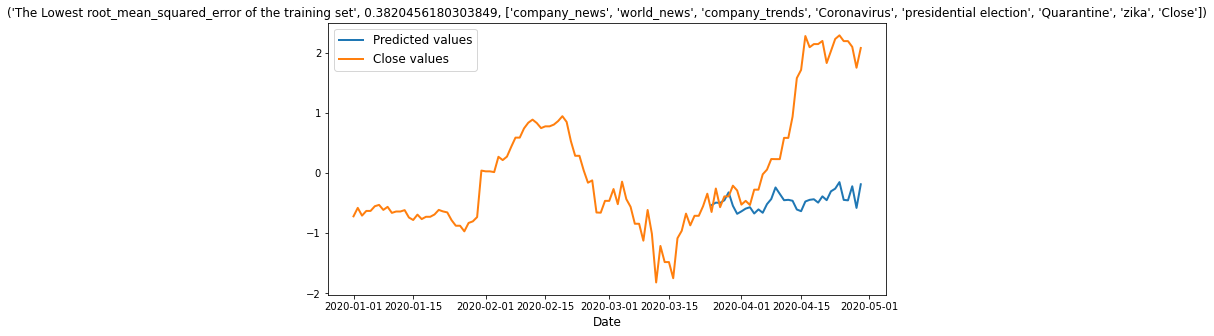

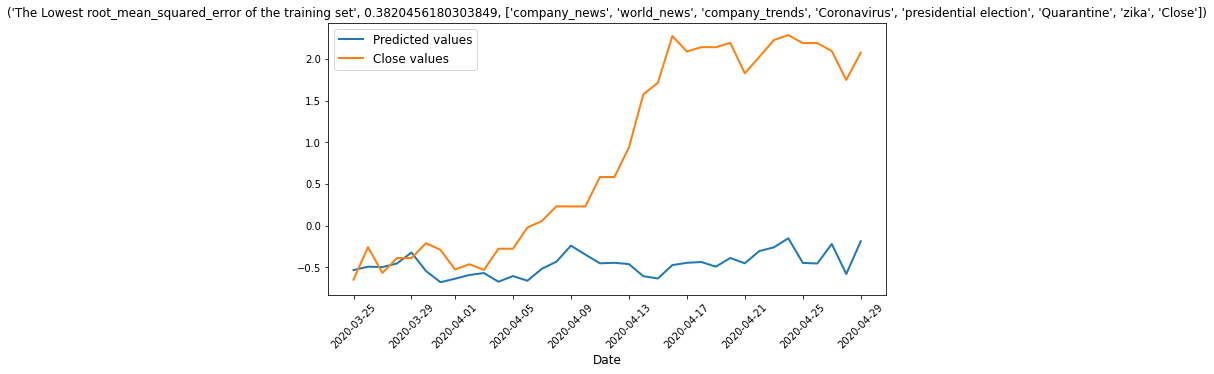

Root_mean_squared_error of the testing set:  1.6958699084073807
neg_mean_squared_error of the testing set:  -1.5770170341946816
mean_absolute_percentage_error of the testing set:  218.77345203307453
R2 score of the testing set:  -1.2783034718930408


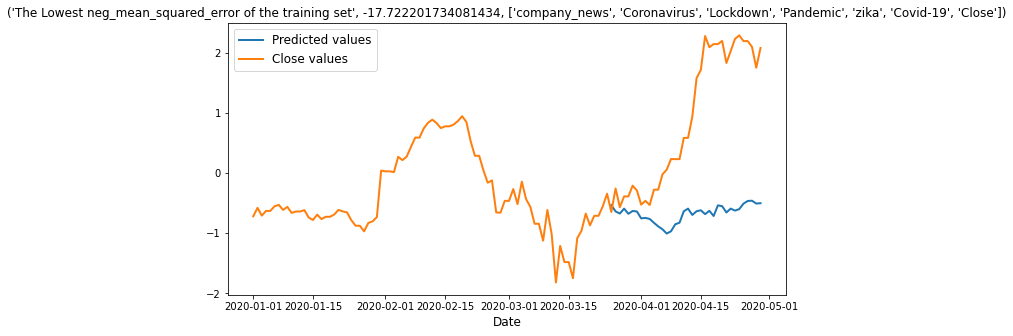

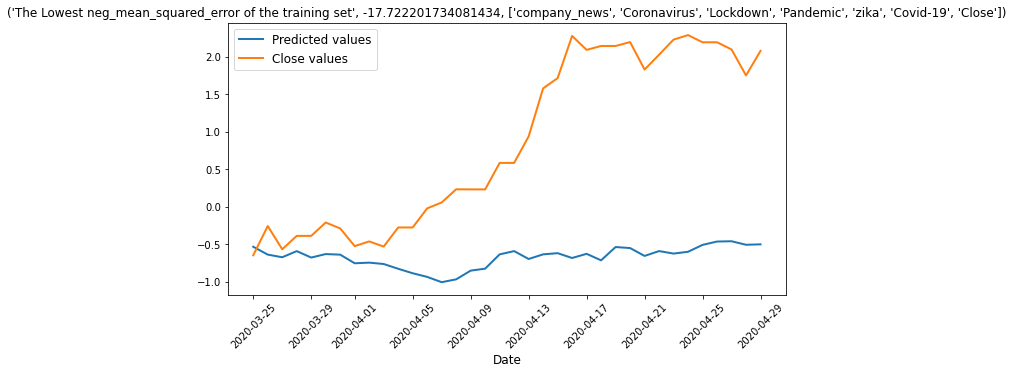

Root_mean_squared_error of the testing set:  1.8563678241834203
neg_mean_squared_error of the testing set:  -13.808747068766806
mean_absolute_percentage_error of the testing set:  315.1233363658027
R2 score of the testing set:  -1.7299492177950841


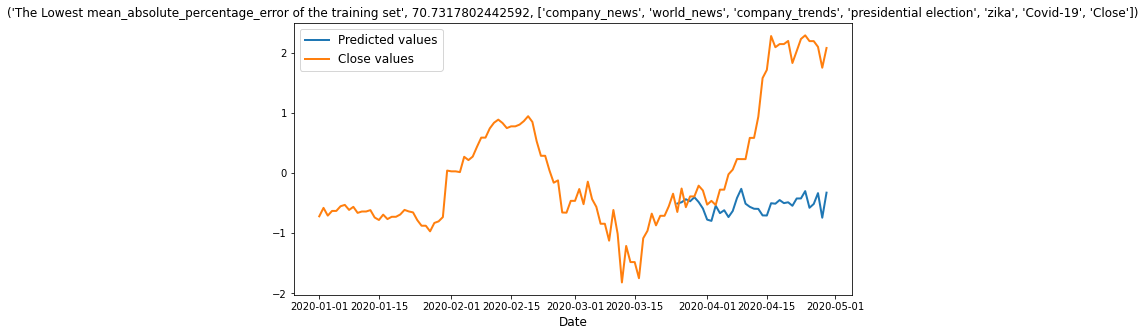

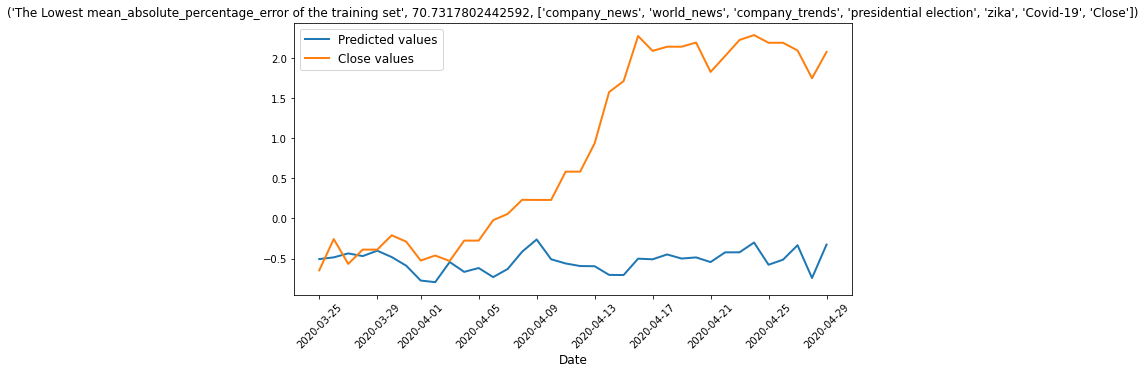

Root_mean_squared_error of the testing set:  1.7677956624443374
neg_mean_squared_error of the testing set:  -0.7787436885765916
mean_absolute_percentage_error of the testing set:  239.47605290124895
R2 score of the testing set:  -1.4756579021576797


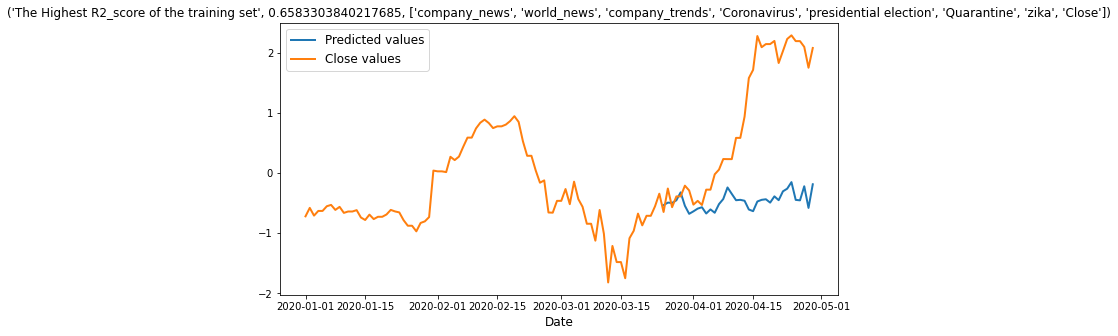

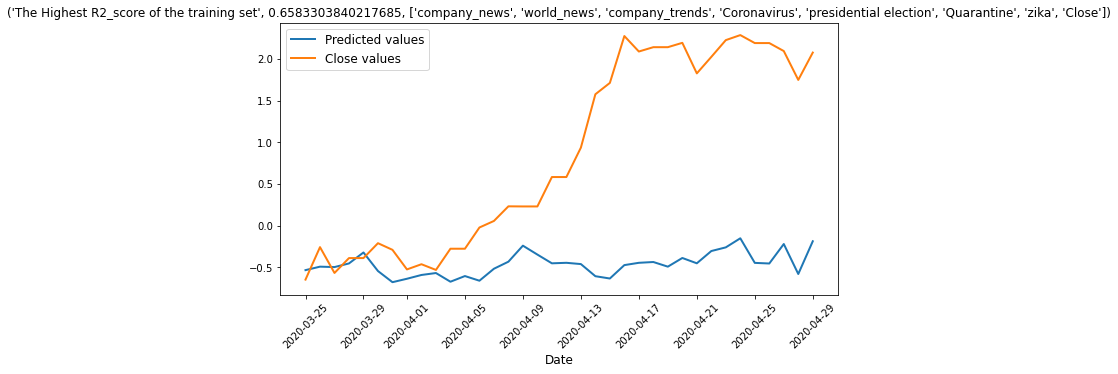

Root_mean_squared_error of the testing set:  1.6958699084073807
neg_mean_squared_error of the testing set:  -1.5770170341946816
mean_absolute_percentage_error of the testing set:  218.77345203307453
R2 score of the testing set:  -1.2783034718930408


In [54]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

#     regressor = SVR(kernel='rbf')
    model.fit(X_train,y_train)
    Y_hat = model.predict(X_test)
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)

In [18]:
features_from_other_timewindows_based_on_Coefficients = [[['zika','Lockdown','time','company_news','Close'],"Zika"],
                                                         [['time','Pandemic','Lockdown','company_trends','Close'],'Election 2012'],
                                                         [['time','zika','company_trends','Lockdown','Close'], 'Election 2016']]

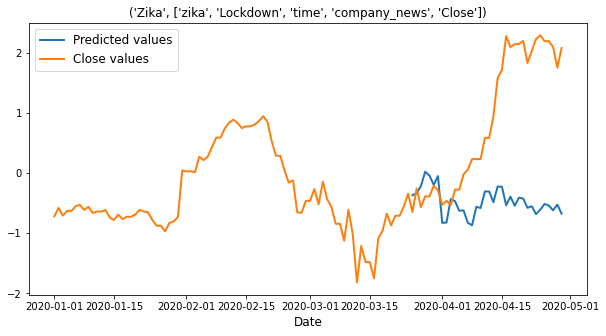

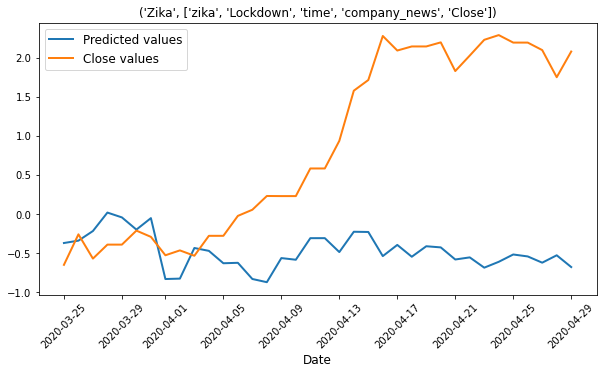

Root_mean_squared_error:  1.7793557785984655
neg_mean_squared_error:  -0.7396400459884871
mean_absolute_percentage_error:  241.46927048785668
R2 score:  -1.5081418221457081


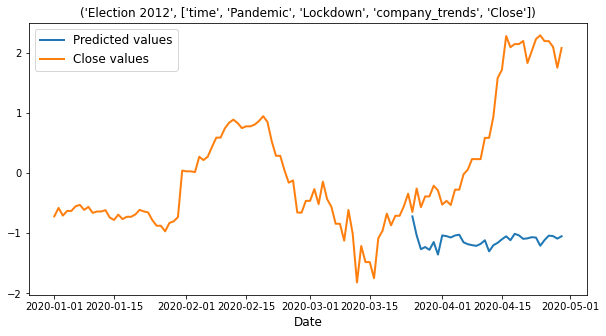

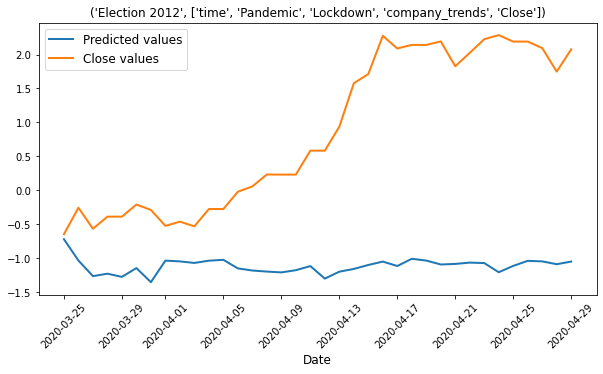

Root_mean_squared_error:  2.262820415074169
neg_mean_squared_error:  -1.2336803766161473
mean_absolute_percentage_error:  418.82687274613284
R2 score:  -3.056268363753815


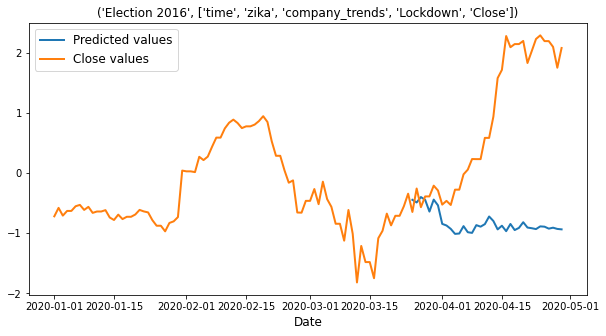

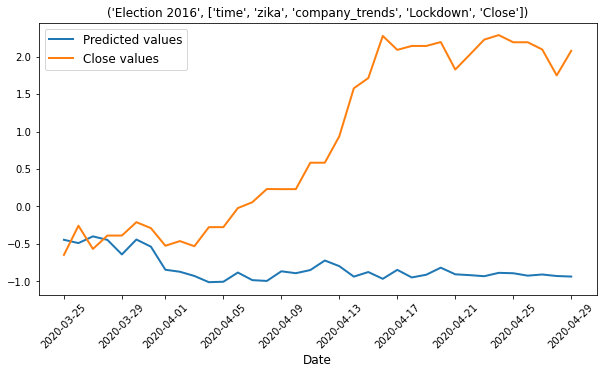

Root_mean_squared_error:  2.075240709088598
neg_mean_squared_error:  -0.33015009646823673
mean_absolute_percentage_error:  317.1870062654519
R2 score:  -2.411642061760236


In [19]:
for k,i in enumerate(features_from_other_timewindows_based_on_Coefficients):

    df_1 = std_df[i[0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

#     regressor = SVR(kernel='rbf')
    model.fit(X_train,y_train)
    Y_hat = model.predict(X_test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0]))
    plt.xticks(rotation=45)
    plt.show()
    
        # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score: ", R2_score)

# Zika

In [20]:
# removing covid_19, coronavirus features which have only 0s.
df = Zika[['company_news', 'world_news', 'company_trends',
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 'zika',
        'time', 'Close']]

In [21]:
df.index = pd.to_datetime(df.index)


In [22]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

In [23]:
cutIdx = int(len(std_df)*0.7)

In [24]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [25]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [26]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
    
#     regressor = SVR(kernel='rbf')    
    model.fit(X_train,y_train)
    Y_hat = model.predict(X_train)


    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [27]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [28]:
# Names = ['The Lowest root_mean_squared_error', 'The Lowest neg_mean_squared_error', 'The Lowest mean_absolute_percentage_error', 'The Highest R2_score']

selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

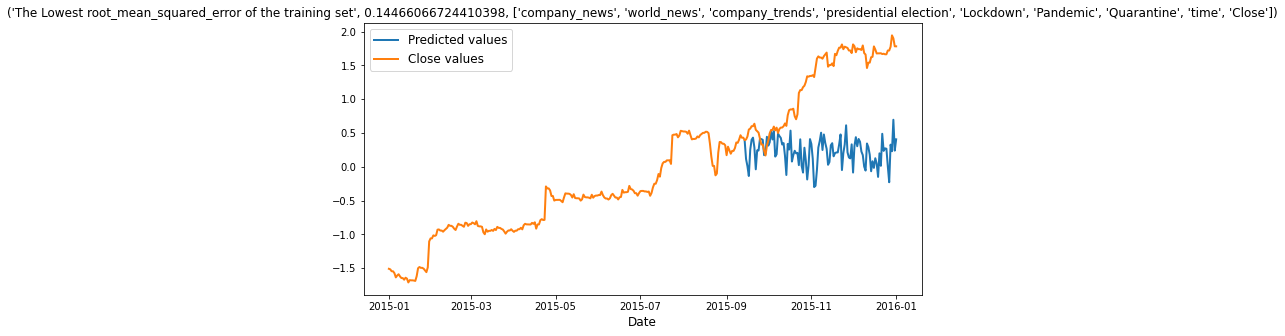

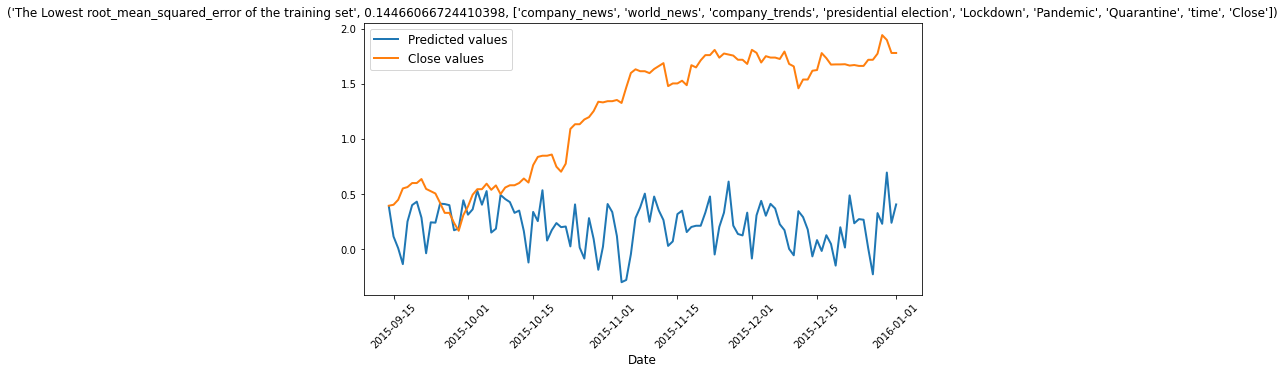

Root_mean_squared_error of the testing set:  1.1760831676702916
neg_mean_squared_error of the testing set:  -0.09643702805150338
mean_absolute_percentage_error of the testing set:  74.3850647425668
R2 score of the testing set:  -3.8251041206033687


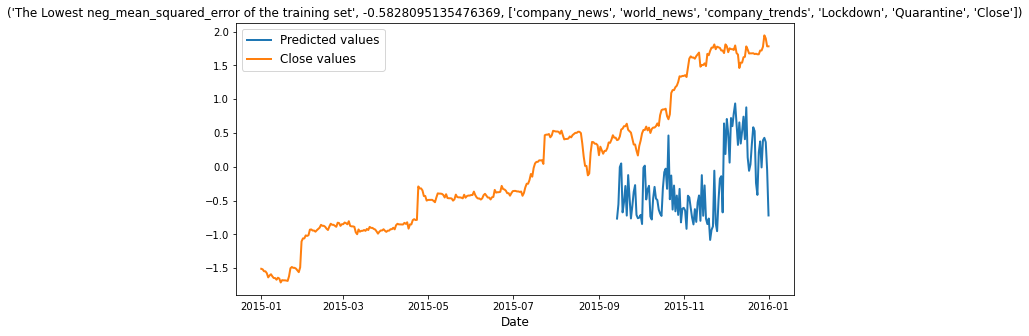

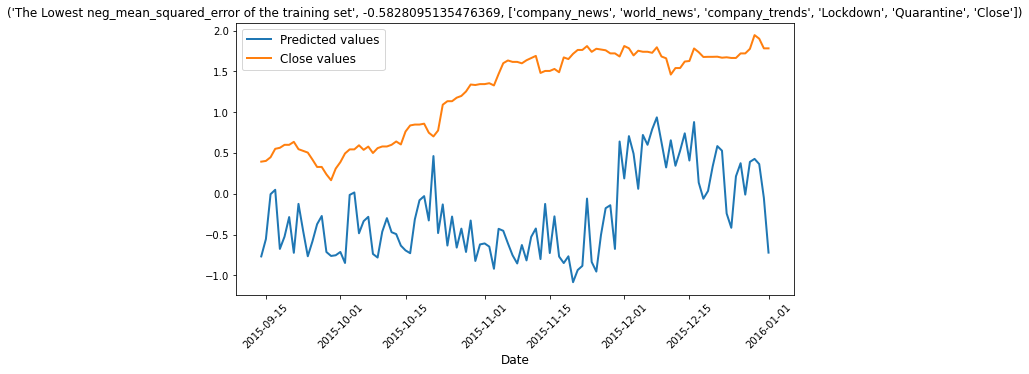

Root_mean_squared_error of the testing set:  1.60675640300203
neg_mean_squared_error of the testing set:  -0.5464540464342479
mean_absolute_percentage_error of the testing set:  141.87418381427318
R2 score of the testing set:  -8.005974217315872


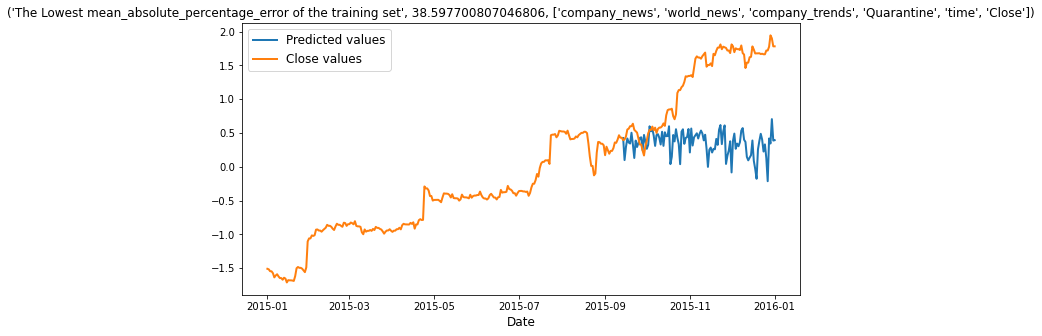

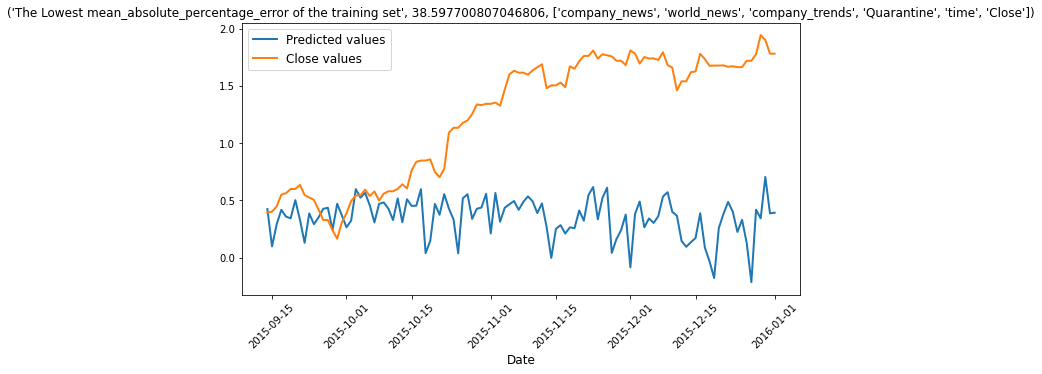

Root_mean_squared_error of the testing set:  1.0598663469350766
neg_mean_squared_error of the testing set:  -0.089458601447861
mean_absolute_percentage_error of the testing set:  63.965146635669015
R2 score of the testing set:  -2.9186170694185


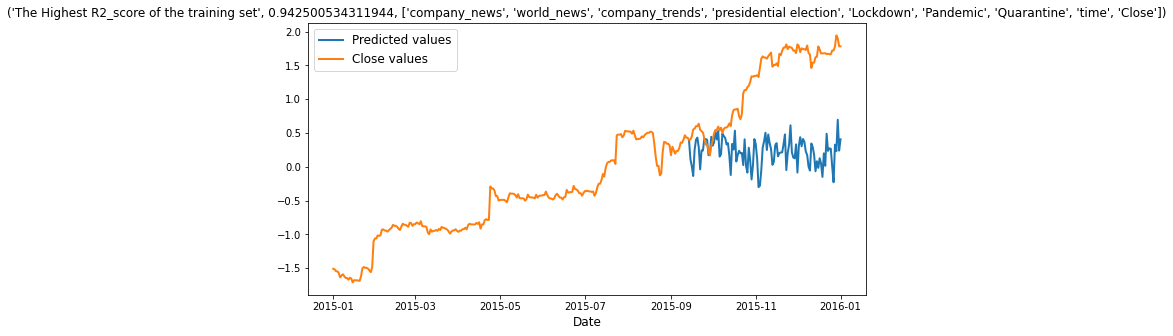

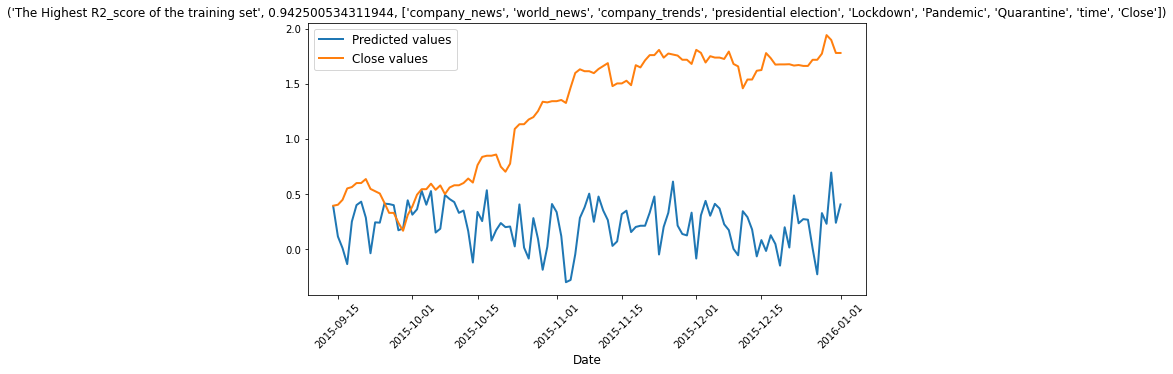

Root_mean_squared_error of the testing set:  1.1760831676702916
neg_mean_squared_error of the testing set:  -0.09643702805150338
mean_absolute_percentage_error of the testing set:  74.3850647425668
R2 score of the testing set:  -3.8251041206033687


In [29]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

#     regressor = SVR(kernel='rbf')
    model.fit(X_train,y_train)
    Y_hat = model.predict(X_test)
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)

# Election 2012

In [30]:
# removing covid_19, coronavirus, zika features which have only 0s.
df = election_2012[['company_news', 'world_news', 'company_trends', 
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 
        'time', 'Close']]

In [31]:
df.index = pd.to_datetime(df.index)


In [32]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

In [33]:
cutIdx = int(len(std_df)*0.7)

In [34]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [35]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [36]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
    
#     regressor = SVR(kernel='rbf')    
    model.fit(X_train,y_train)
    Y_hat = model.predict(X_train)


    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [37]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [38]:
# Names = ['The Lowest root_mean_squared_error', 'The Lowest neg_mean_squared_error', 'The Lowest mean_absolute_percentage_error', 'The Highest R2_score']

selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

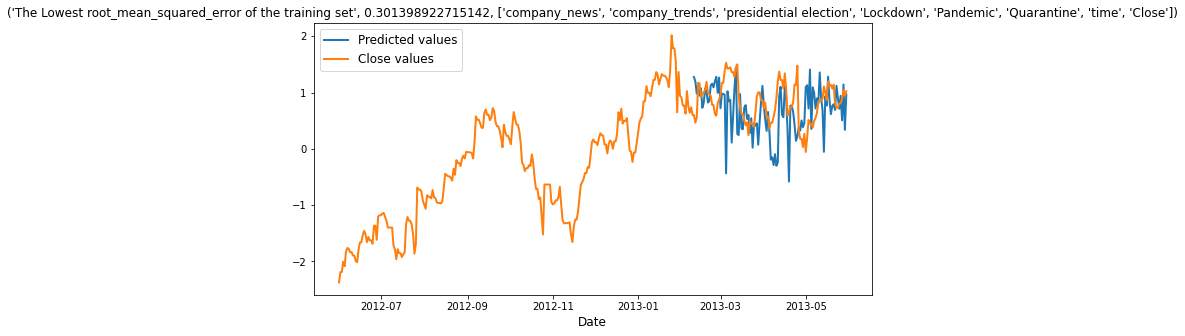

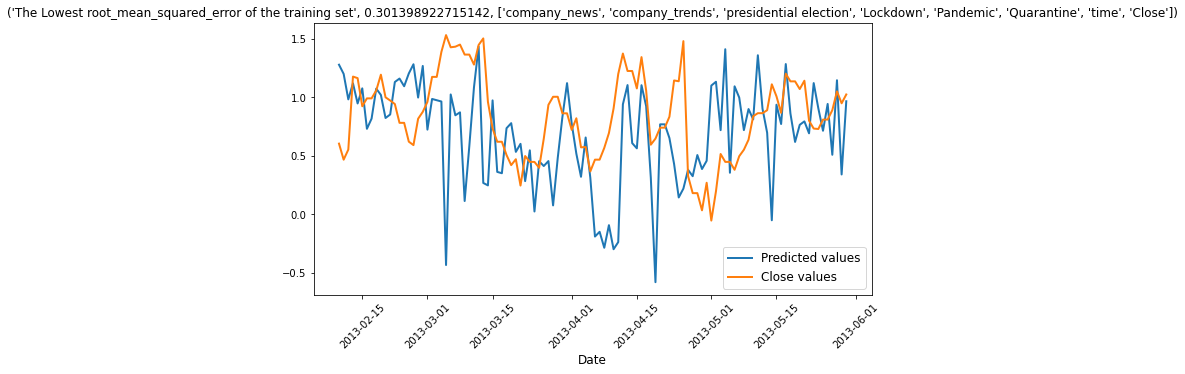

Root_mean_squared_error of the testing set:  0.5472364851049604
neg_mean_squared_error of the testing set:  -0.26258524048197224
mean_absolute_percentage_error of the testing set:  83.43770045453539
R2 score of the testing set:  -1.433761481449194


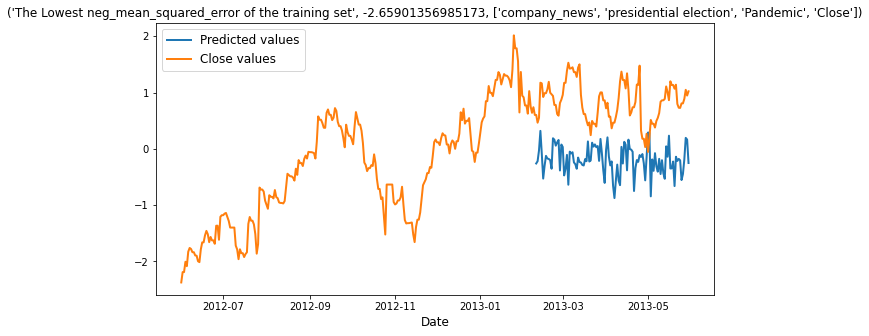

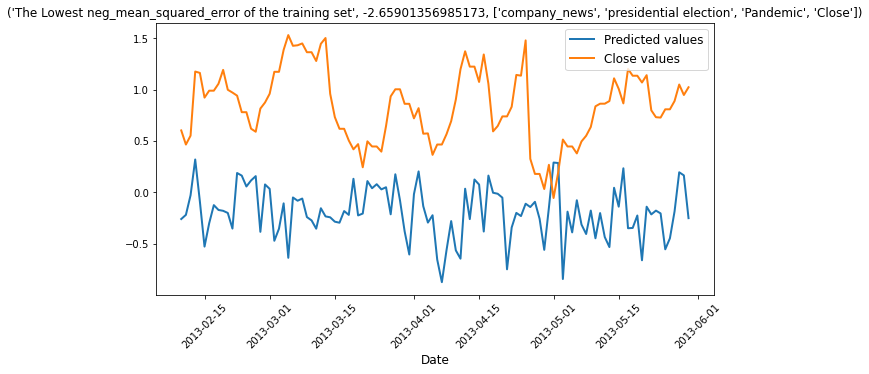

Root_mean_squared_error of the testing set:  1.1161977577190638
neg_mean_squared_error of the testing set:  -0.16211966828575164
mean_absolute_percentage_error of the testing set:  147.180012218042
R2 score of the testing set:  -9.125353987664967


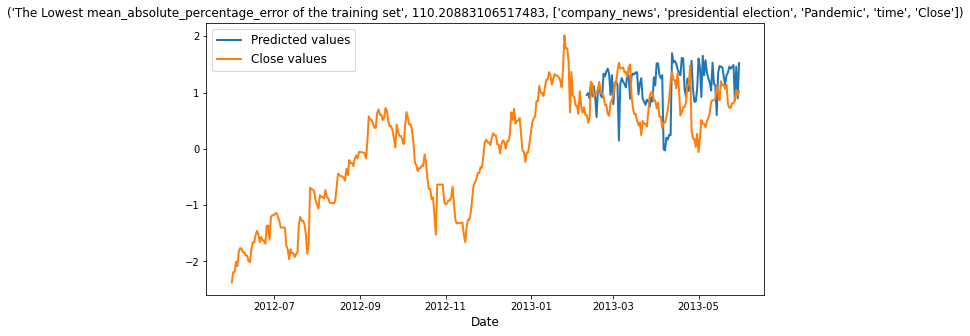

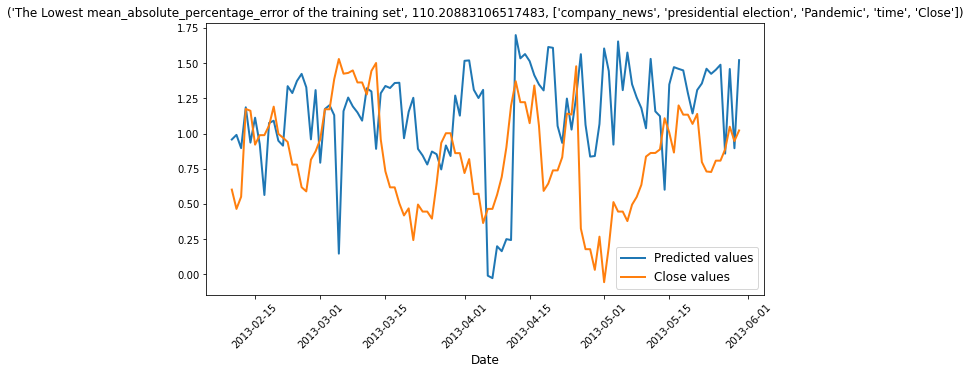

Root_mean_squared_error of the testing set:  0.578774524067849
neg_mean_squared_error of the testing set:  -0.30391327165273335
mean_absolute_percentage_error of the testing set:  132.141743334898
R2 score of the testing set:  -1.7223674085085148


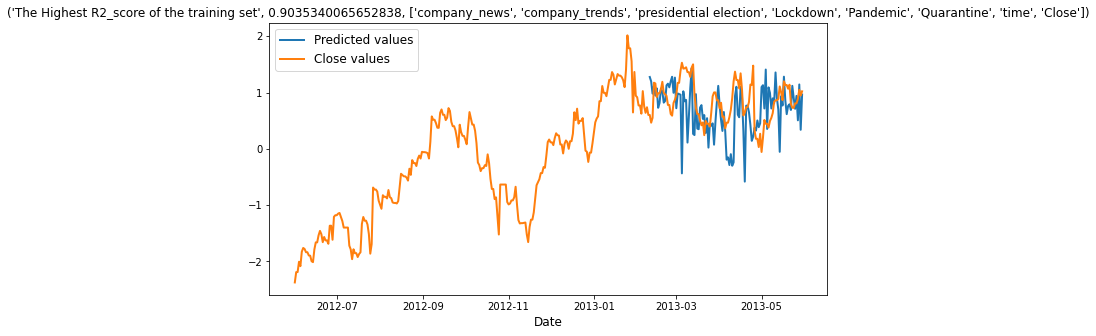

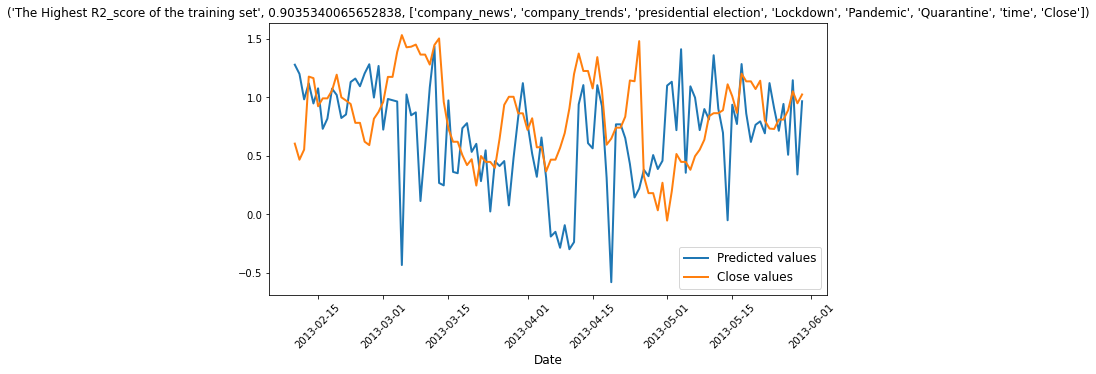

Root_mean_squared_error of the testing set:  0.5472364851049604
neg_mean_squared_error of the testing set:  -0.26258524048197224
mean_absolute_percentage_error of the testing set:  83.43770045453539
R2 score of the testing set:  -1.433761481449194


In [39]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

#     regressor = SVR(kernel='rbf')
    model.fit(X_train,y_train)
    Y_hat = model.predict(X_test)
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)

# Election 2016

In [40]:
# removing covid_19, coronavirus features which have only 0s.
df = election_2016[['company_news', 'world_news', 'company_trends', 
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine','zika',
        'time', 'Close']]

In [41]:
df.index = pd.to_datetime(df.index)


In [42]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

In [43]:
cutIdx = int(len(std_df)*0.7)

In [44]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [45]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [46]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
    
#     regressor = SVR(kernel='rbf')    
    model.fit(X_train,y_train)
    Y_hat = model.predict(X_train)


    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [47]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [48]:
# Names = ['The Lowest root_mean_squared_error', 'The Lowest neg_mean_squared_error', 'The Lowest mean_absolute_percentage_error', 'The Highest R2_score']

selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

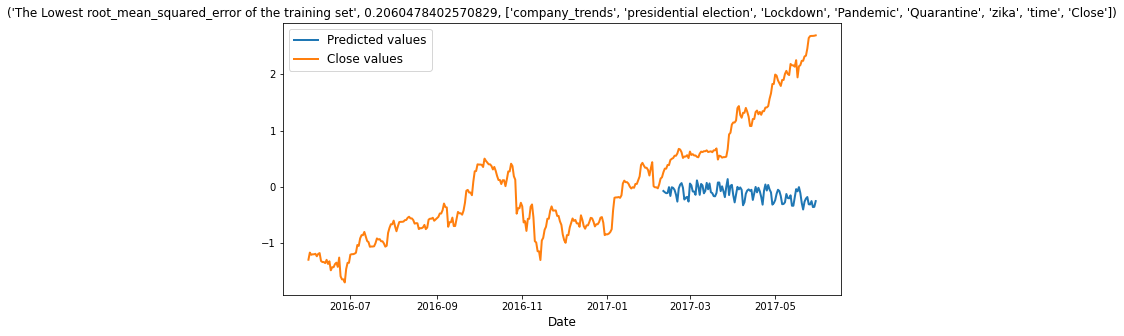

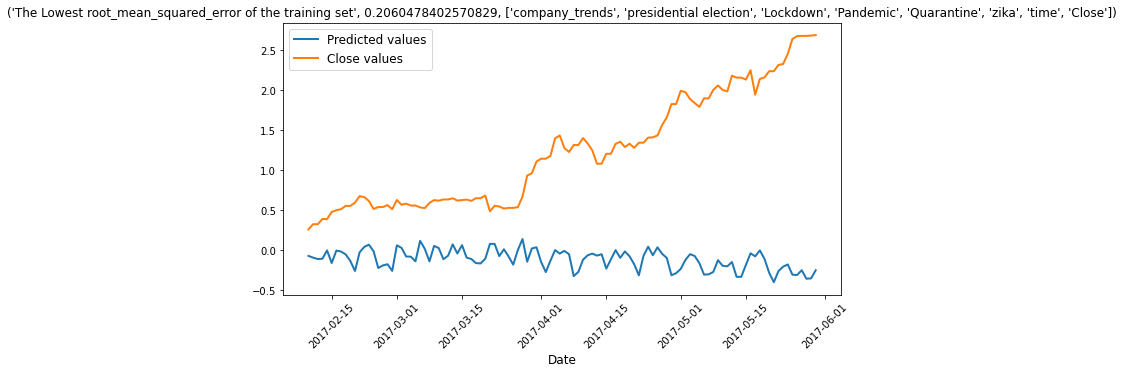

Root_mean_squared_error of the testing set:  1.5556982583516739
neg_mean_squared_error of the testing set:  -0.08657036644178437
mean_absolute_percentage_error of the testing set:  109.86115673338317
R2 score of the testing set:  -3.908197383439406


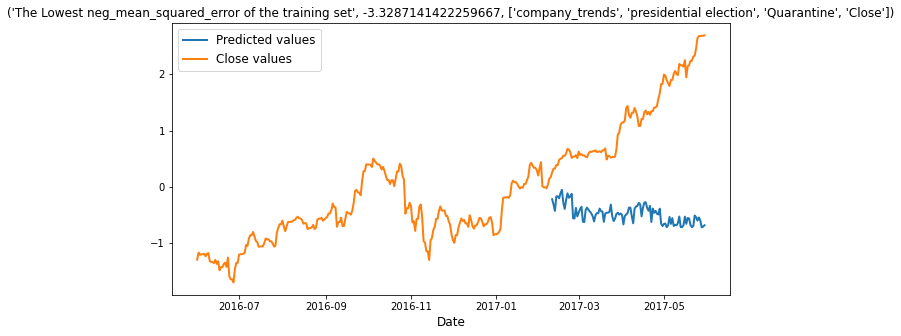

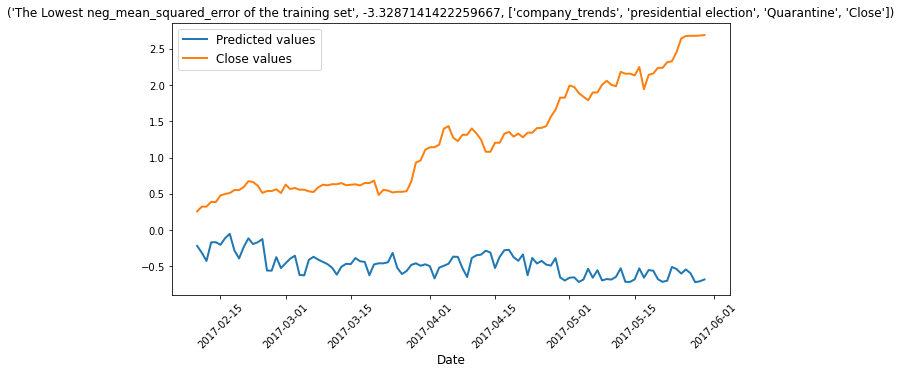

Root_mean_squared_error of the testing set:  1.890529761279847
neg_mean_squared_error of the testing set:  -0.43130101857518677
mean_absolute_percentage_error of the testing set:  148.90113171903886
R2 score of the testing set:  -6.248336143549766


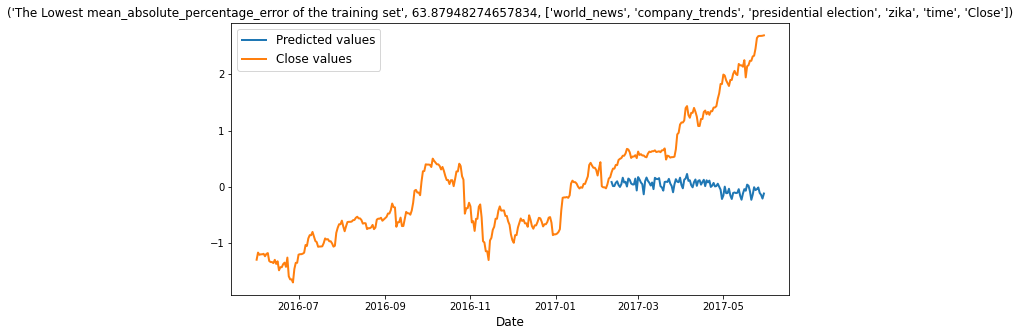

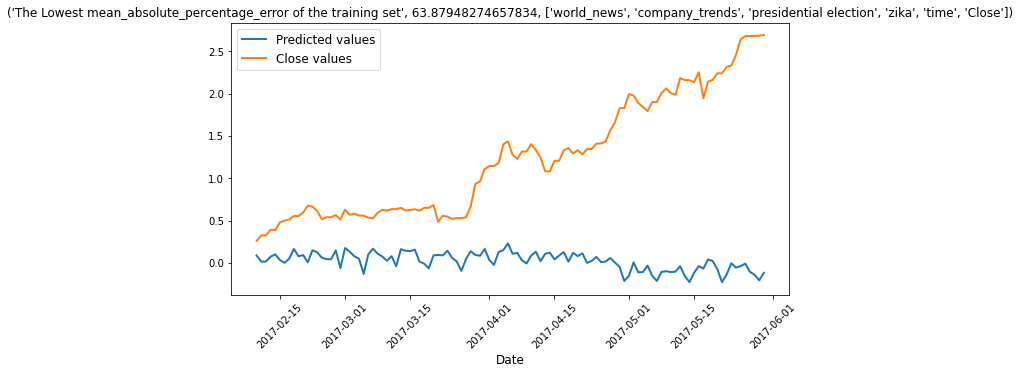

Root_mean_squared_error of the testing set:  1.43613097766216
neg_mean_squared_error of the testing set:  -0.08072602006127412
mean_absolute_percentage_error of the testing set:  94.39302099937845
R2 score of the testing set:  -3.182725738732656


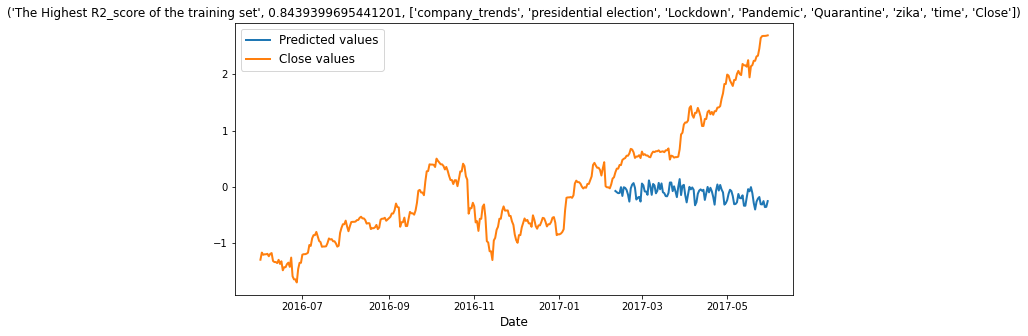

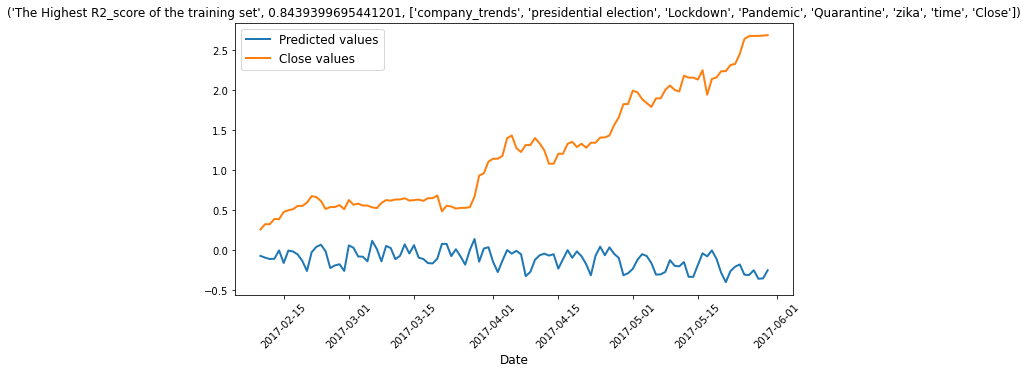

Root_mean_squared_error of the testing set:  1.5556982583516739
neg_mean_squared_error of the testing set:  -0.08657036644178437
mean_absolute_percentage_error of the testing set:  109.86115673338317
R2 score of the testing set:  -3.908197383439406


In [49]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

#     regressor = SVR(kernel='rbf')
    model.fit(X_train,y_train)
    Y_hat = model.predict(X_test)
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)

# 10 years

In [50]:
# removing covid_19, coronavirus features which have only 0s.
df = Company


In [51]:
df.index = pd.to_datetime(df.index)


In [52]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

In [53]:
cutIdx = int(len(std_df)*0.7)

In [54]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [55]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [56]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
    
#     regressor = SVR(kernel='rbf')    
    model.fit(X_train,y_train)
    Y_hat = model.predict(X_train)


    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [57]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [58]:
# Names = ['The Lowest root_mean_squared_error', 'The Lowest neg_mean_squared_error', 'The Lowest mean_absolute_percentage_error', 'The Highest R2_score']

selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

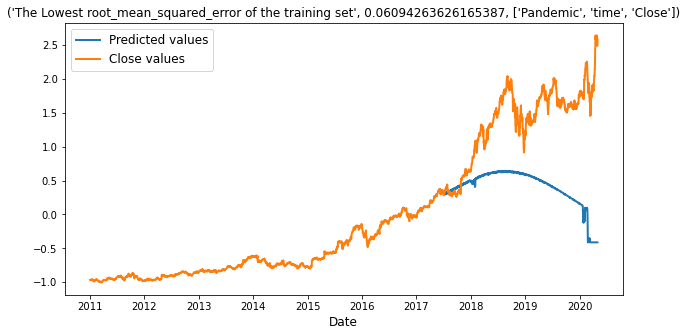

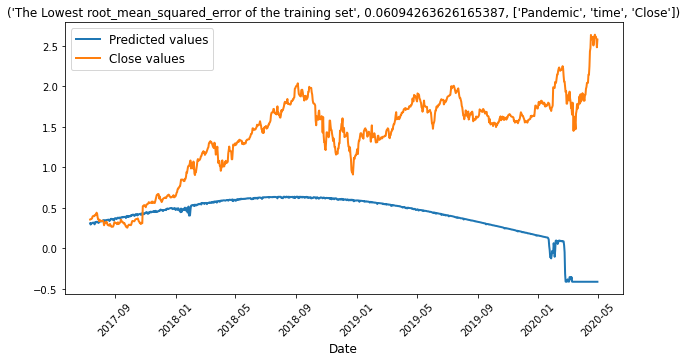

Root_mean_squared_error of the testing set:  1.1788495466242
neg_mean_squared_error of the testing set:  -0.18684071455421486
mean_absolute_percentage_error of the testing set:  63.10772414728093
R2 score of the testing set:  -4.051755917800263


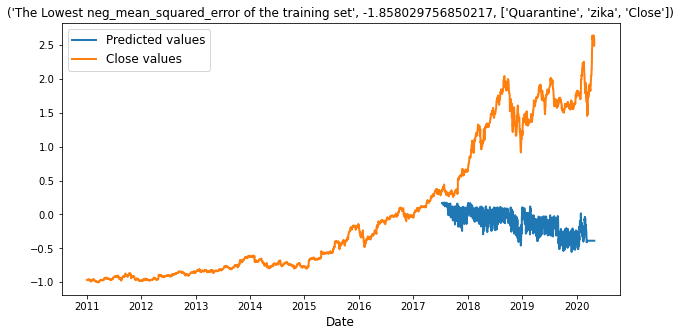

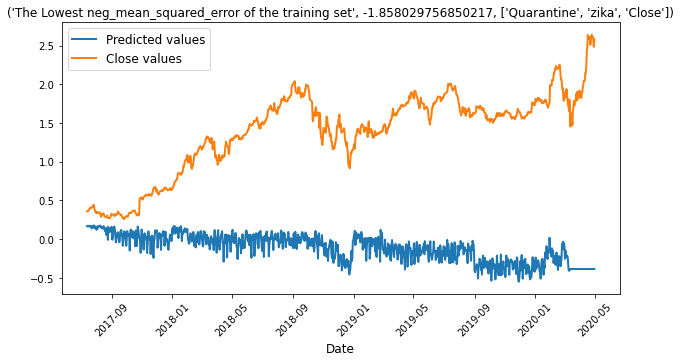

Root_mean_squared_error of the testing set:  1.6297956257878858
neg_mean_squared_error of the testing set:  -27.155024179146306
mean_absolute_percentage_error of the testing set:  104.46788217380572
R2 score of the testing set:  -8.655880737056634


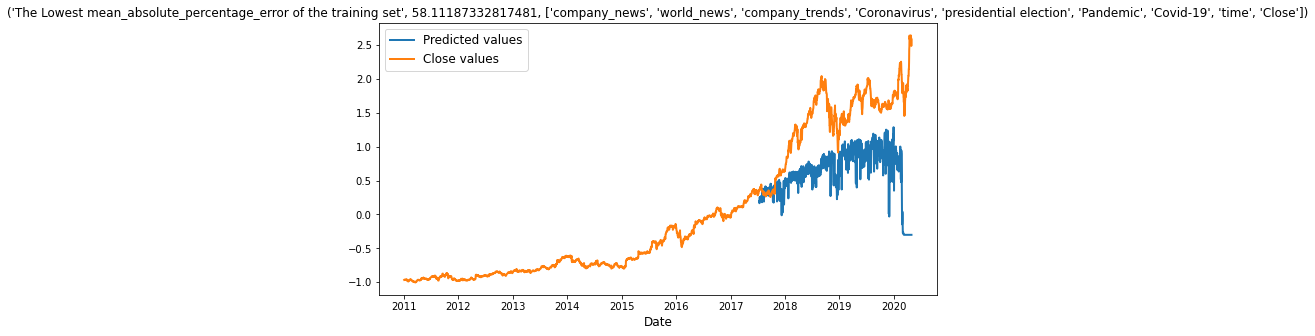

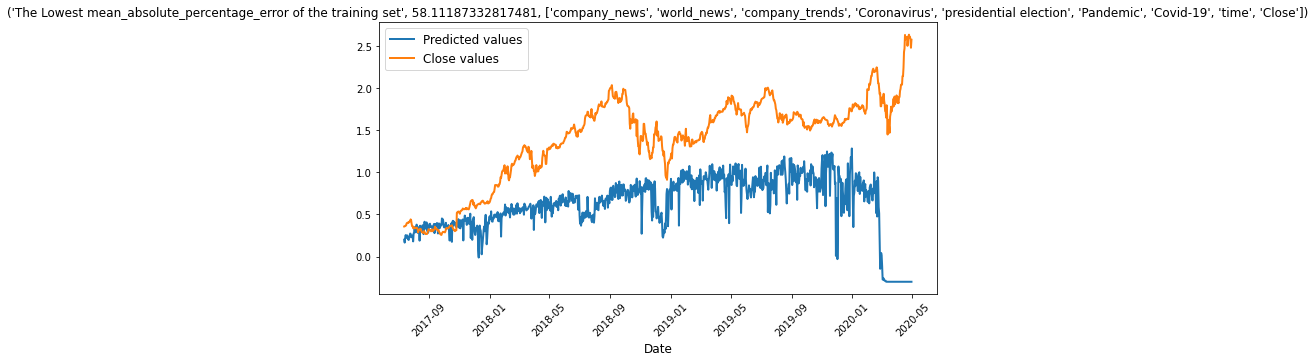

Root_mean_squared_error of the testing set:  0.9326529418387061
neg_mean_squared_error of the testing set:  -1.3816965627093745
mean_absolute_percentage_error of the testing set:  50.46031428598853
R2 score of the testing set:  -2.162028108129436


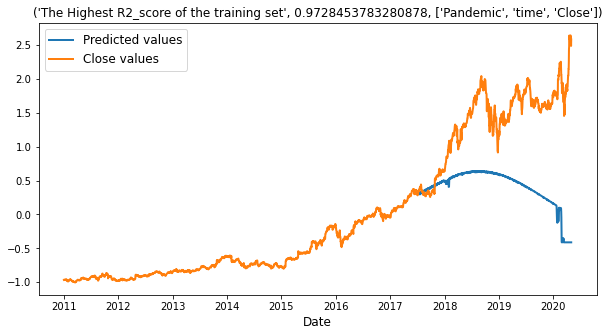

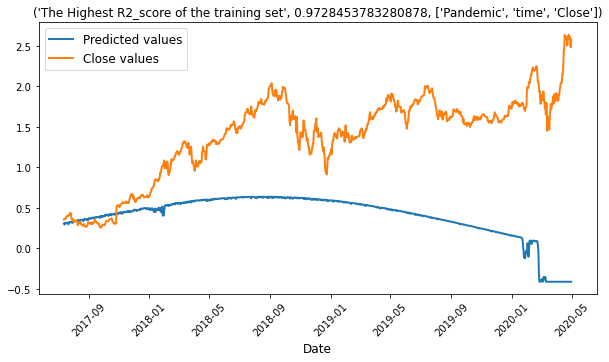

Root_mean_squared_error of the testing set:  1.1788495466242
neg_mean_squared_error of the testing set:  -0.18684071455421486
mean_absolute_percentage_error of the testing set:  63.10772414728093
R2 score of the testing set:  -4.051755917800263


In [59]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

#     regressor = SVR(kernel='rbf')
    model.fit(X_train,y_train)
    Y_hat = model.predict(X_test)
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)